In [377]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [378]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0],bias=False)
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1],bias=False))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [379]:
INPUT_SIZE=784
HIDDEN_SIZES=[600,600]
OUTPUT_SIZE=10
BATCH_SIZE=256
LEARNING_RATE=0.01
MOMENTUM=0.95
NUM_EPOCHS=200

In [380]:
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

test_dataset_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) 

In [381]:
def network_parameters(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            for l in para[1].detach().tolist():
                network_weights+=l
        else:
            network_weights+=para[1].detach().tolist()
    return network_weights

In [382]:
def normalized_CrossEntropyLoss(predictions,target):
    return nn.CrossEntropyLoss()(predictions,target)/np.log(10)

In [383]:
def train_epoch(model,opt,loader):
    for images, labels in loader:  
        images = images.reshape(-1, 28*28)
        
        outputs = model(images)
        loss = normalized_CrossEntropyLoss(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()

def SGD_Alg(model,opt,S,b,t,stopping_criteria,stop_at_zero=False):
    ind=list(np.arange(len(S)))
    for i in range(t):
        N=len(ind)
        if N>=b:
            sample_ind=np.random.choice(ind,b,replace=False)
            subset=Subset(S,sample_ind)
            subset_loader=DataLoader(subset,batch_size=b)
            loss=train_epoch(model,opt,subset_loader)
            for entry in sample_ind:
                ind.remove(entry)
        elif N>0:
            subset=Subset(S,ind)
            subset_loader=DataLoader(subset,batch_size=b)
            loss=train_epoch(model,opt,subset_loader)
            ind=[]
        else:
            if stop_at_zero:
                break
            else:
                ind=list(np.arange(len(S)))
        if loss<stopping_criteria:
            break

In [384]:
import copy

def get_bound(base_model,alpha,data_set,stopping_criteria,sigma_P,beta=0.5,delta=0.05):

    def get_weights(model,alpha,stopping_criteria,Dataset,T=2000):

        N=len(Dataset)
        Subset_ind=list(range(int(N*alpha)))

        Subset_Dataset=Subset(Dataset,Subset_ind)

        model_prefix=copy.deepcopy(model)
        opt_prefix = SGD(model_prefix.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM)
        SGD_Alg(model_prefix,opt_prefix,Subset_Dataset,256,T,stopping_criteria,stop_at_zero=True)

        model_base=copy.deepcopy(model_prefix)
        opt_base = SGD(model_base.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM)
        SGD_Alg(model_base,opt_base,Dataset,256,T,stopping_criteria)

        w_base=network_parameters(model_base)
        w_prefix=network_parameters(model_prefix)

        return w_base,w_prefix,model_base

    w_S,w_alpha,base_model=get_weights(base_model,alpha,stopping_criteria,data_set)

    with torch.no_grad():
        loss=0
        n=0
        for images, labels in test_dataset_loader:
            n+=1
            images = images.reshape(-1, 28*28)
            outputs = base_model(images)
            loss+=normalized_CrossEntropyLoss(outputs,labels)
        empirical_risk=loss/n

    KL=np.linalg.norm(np.array(w_S)-np.array(w_alpha))/(sigma_P*2)
    return empirical_risk/beta+(KL+np.log(1/delta))/(2*beta*(1-beta)*(len(data_set)*(1-alpha)))


In [385]:
alpha_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
bounds=[]
for alpha in alpha_list:
    print(alpha)
    base_model=NeuralNet(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
    ReLU_glorot_init(base_model)
    bounds.append(get_bound(base_model,alpha,train_dataset,0.1,1e-3))

0.1


0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


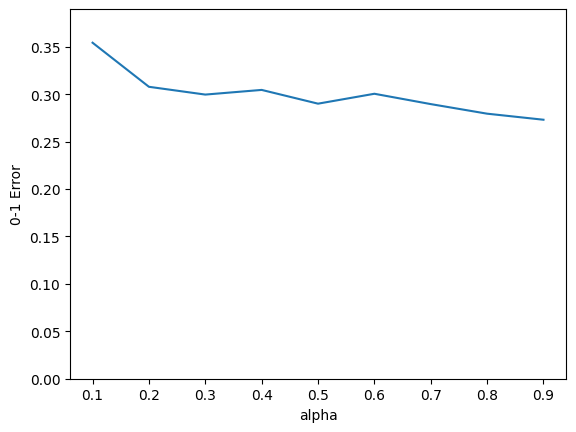

In [391]:
plt.plot(alpha_list,bounds)
plt.ylim((0,max(bounds)*1.1))
plt.ylabel('0-1 Error')
plt.xlabel('alpha')
plt.savefig('plots/PAC_Bounds_via_SGD.png')